Reference [code](https://github.com/seantalts/simulation-based-calibration) and [paper](https://arxiv.org/abs/1804.06788)

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from tqdm import trange


DTYPE = np.float32

In [2]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp

if DTYPE is np.float64:
    from jax.config import config
    config.update("jax_enable_x64", True)

tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
seed = jax.random.PRNGKey(9827346592678)

# 1 run

In [4]:
N = 25
seed, random_seed = jax.random.split(seed, 2)
design_matrix = jax.random.normal(random_seed, shape=[N], dtype=DTYPE) * 5.

true_model = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=10.),
    tfd.Normal(loc=0., scale=10.),
    tfd.HalfNormal(scale=2.5),
    lambda sigma, alpha, beta: tfd.Independent(
        tfd.Normal(loc=design_matrix * beta[..., None] + alpha[..., None],
                   scale=sigma[..., None]),
        reinterpreted_batch_ndims=1
    )
])

true_model.log_prob_parts(true_model.sample(5, seed=random_seed))

[DeviceArray([-3.4320207, -5.6709275, -3.239232 , -3.289321 , -4.6581144],            dtype=float32),
 DeviceArray([-3.7172241, -4.1776147, -3.3981676, -3.2427752, -4.5667176],            dtype=float32),
 DeviceArray([-1.3875328, -1.1581423, -1.2498174, -1.3414471, -1.1710361],            dtype=float32),
 DeviceArray([-50.1099  , -11.915036, -42.021366, -45.77529 , -20.356224],            dtype=float32)]

In [5]:
beta, alpha, sigma, y = true_model.sample(seed=random_seed)
beta, alpha, sigma, y

(DeviceArray(-7.789698, dtype=float32),
 DeviceArray(-13.161949, dtype=float32),
 DeviceArray(1.1822749, dtype=float32),
 DeviceArray([-24.927372 ,  14.440689 ,  11.877046 ,   3.576068 ,
               28.54598  ,  -8.205143 , -20.207355 , -69.199    ,
              -13.909412 ,  35.677933 , -34.773438 ,  10.502798 ,
              -42.599087 ,  47.810806 ,   1.3702252,  11.80415  ,
               49.650253 , 104.234245 , -23.533915 , -80.54551  ,
              -42.110516 ,  62.07003  ,  41.004375 , -29.971672 ,
               -7.738711 ], dtype=float32))

In [6]:
#@title Sample with Batched NUTS
unnest = tfp.internal.unnest

def gen_nuts_sample_fn(target_log_prob_fn, bijector, draws, tune):

  @jax.jit
  def run_inference_nuts(init_state, seed):
    seed, tuning_seed, sample_seed = jax.random.split(seed, 3)
    def gen_kernel(step_size):
      hmc = tfp.mcmc.NoUTurnSampler(
          target_log_prob_fn=target_log_prob_fn, step_size=step_size)
      hmc = tfp.mcmc.TransformedTransitionKernel(
          hmc, bijector=bijector)
      tuning_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
          hmc, tune // 2, target_accept_prob=0.85)
      return tuning_hmc

    def tuning_trace_fn(_, pkr): 
      return (pkr.inner_results.transformed_state,
              pkr.new_step_size)

    def get_tuned_stepsize(samples, step_size):
      return jnp.std(samples, axis=0) * step_size[-1]

    step_size = jax.tree_map(lambda x: jnp.ones_like(x), init_state)
    tuning_hmc = gen_kernel(step_size)
    init_samples, tuning_result = tfp.mcmc.sample_chain(
        num_results=200,
        num_burnin_steps=tune // 2 - 200,
        current_state=init_state,
        kernel=tuning_hmc,
        trace_fn=tuning_trace_fn,
        seed=tuning_seed)
    
    step_size_new = jax.tree_multimap(get_tuned_stepsize, *tuning_result)
    sample_hmc = gen_kernel(step_size_new)
    def sample_trace_fn(_, pkr):
      return (
          unnest.get_innermost(pkr, 'target_log_prob'),
          unnest.get_innermost(pkr, 'leapfrogs_taken'),
          unnest.get_innermost(pkr, 'has_divergence'),
          unnest.get_innermost(pkr, 'energy'),
          unnest.get_innermost(pkr, 'log_accept_ratio'),
          unnest.get_innermost(pkr, 'reach_max_depth'),
      )
    return tfp.mcmc.sample_chain(
        num_results=draws,
        num_burnin_steps=tune // 2,
        current_state=[x[-1] for x in init_samples],
        kernel=sample_hmc,
        trace_fn=sample_trace_fn,
        seed=sample_seed)
  
  return run_inference_nuts

In [7]:
target_log_prob_fn = lambda *x: true_model.log_prob(*x, y)

seed, init_seed = jax.random.split(seed, 2)
init_state = true_model.sample(5, seed=init_seed)[:-1]
target_log_prob_fn(*init_state)

DeviceArray([ -6947.595  ,   -113.17155, -35393.992  ,  -9562.572  ,
              -8761.259  ], dtype=float32)

In [8]:
bijectors = [tfb.Identity(), tfb.Identity(), tfb.Exp()]

In [9]:
nchain = 5
init_state = true_model.sample(nchain, seed=init_seed)[:-1]

seed, *init_seed = jax.random.split(seed, len(init_state)+1)

init_state_ = jax.tree_multimap(lambda bij, x, rng: jnp.asarray(
    bij.forward(
        tfd.Uniform(-1., 1.).sample(bij.inverse(x).shape, seed=rng)),
    dtype=x.dtype),
    bijectors, list(init_state), init_seed)

In [10]:
run_inference = gen_nuts_sample_fn(target_log_prob_fn, bijectors, 500, 1000)

In [11]:
%%time
seed, inference_seed = jax.random.split(seed, 2)
nuts_samples, sampler_stats = run_inference(init_state_, inference_seed)
_ = nuts_samples[0].block_until_ready()

CPU times: user 9.22 s, sys: 135 ms, total: 9.36 s
Wall time: 9.37 s


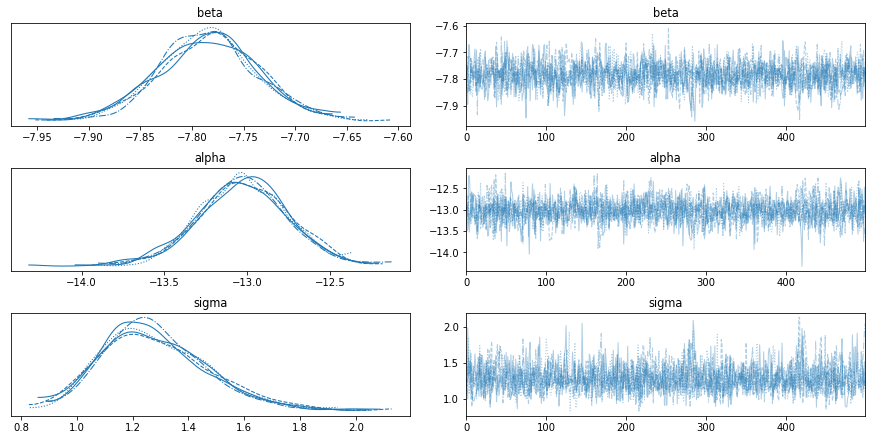

In [12]:
# using the pymc3 naming convention
posterior = {
    k: v.T
    for k, v in zip(['beta', 'alpha', 'sigma'], nuts_samples)}

sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k: v.T for k, v in zip(sample_stats_name, sampler_stats)}

nuts_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)
axes = az.plot_trace(nuts_trace, compact=True);

# SMC

In [13]:
def order_stat(prior, samples):
    return jnp.sum(prior < samples)

def mean_stat(prior, samples):
    return jnp.mean(prior < samples)

def rmse_mean(prior, samples):
    return jnp.sqrt(jnp.square(jnp.mean(samples) - prior))

def rmse_averaged(prior, samples):
    return jnp.sqrt(jnp.sum(jnp.square(samples - prior)))

def ess(prior, samples):
    del prior
    return tfp.mcmc.diagnostic.effective_sample_size(samples).sum()

def rhat(prior, samples):
    del prior
    return tfp.mcmc.diagnostic.potential_scale_reduction(samples)

diagnostic_fns = [
    order_stat,
    mean_stat,
    rmse_mean,
    rmse_averaged,
    ess,
    rhat
]

## Wide linear regression unthin with incorrect prior

In [14]:
wide_lin_regr = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),  #  <== note the wrong prior here
    tfd.Normal(loc=0., scale=10.),
    tfd.HalfNormal(scale=2.5),
    lambda sigma, alpha, beta: tfd.Independent(
        tfd.Normal(loc=design_matrix * beta[..., None] + alpha[..., None],
                   scale=sigma[..., None]),
        reinterpreted_batch_ndims=1
    )
])

In [15]:
#@title gen_sbc
def gen_sbc(target_model, bijector, nchain, draws, tune):

    @jax.jit
    def run_sbc(true_param, observed, seed):
        init_state_placeholder = target_model.sample(nchain, seed=seed)[:-1]
        
        seed, *init_seed = jax.random.split(seed, len(init_state_placeholder) + 1)
        init_state = jax.tree_multimap(lambda bij, x, rng: jnp.asarray(
            bij.forward(
                tfd.Uniform(-1., 1.).sample(bij.inverse(x).shape, seed=rng)),
            dtype=x.dtype),
            bijector, init_state_placeholder, init_seed)
        target_log_prob_fn = lambda *x: target_model.log_prob(*x, observed)

        seed, tuning_seed, sample_seed = jax.random.split(seed, 3)
        def gen_kernel(step_size):
            hmc = tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=target_log_prob_fn, step_size=step_size)
            hmc = tfp.mcmc.TransformedTransitionKernel(
                hmc, bijector=bijector)
            tuning_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
                hmc, tune // 2, target_accept_prob=0.85)
            return tuning_hmc

        def tuning_trace_fn(_, pkr): 
            return (pkr.inner_results.transformed_state,
                    pkr.new_step_size)

        def get_tuned_stepsize(samples, step_size):
            return jnp.std(samples, axis=0) * step_size[-1]

        step_size = jax.tree_map(lambda x: jnp.ones_like(x), init_state)
        tuning_hmc = gen_kernel(step_size)
        init_samples, tuning_result = tfp.mcmc.sample_chain(
            num_results=200,
            num_burnin_steps=tune // 2 - 200,
            current_state=init_state,
            kernel=tuning_hmc,
            trace_fn=tuning_trace_fn,
            seed=tuning_seed)

        step_size_new = jax.tree_multimap(get_tuned_stepsize, *tuning_result)
        sample_hmc = gen_kernel(step_size_new)

        trace = tfp.mcmc.sample_chain(
            num_results=draws,
            num_burnin_steps=tune // 2,
            current_state=[x[-1] for x in init_samples],
            kernel=sample_hmc,
            trace_fn=None,
            seed=sample_seed)

        result = [jax.tree_multimap(fn, true_param, trace) for fn in diagnostic_fns]
        return jnp.asarray(result).flatten()

    return run_sbc

In [16]:
run_sbc = gen_sbc(wide_lin_regr, bijectors, nchain, 500, 1000)

In [17]:
%%time
seed, inference_seed = jax.random.split(seed, 2)

result = run_sbc([beta, alpha, sigma], y, inference_seed)
_ = result.block_until_ready()

/opt/miniconda3/lib/python3.8/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 13.9 s, sys: 114 ms, total: 14 s
Wall time: 14 s


In [18]:
num_sbc_reps = 5000

In [19]:
beta_sbc, alpha_sbc, sigma_sbc, y_sbc = true_model.sample(num_sbc_reps, seed=random_seed)

In [20]:
seed, *inference_seed = jax.random.split(seed, num_sbc_reps+1)

In [21]:
sbc_result = np.zeros((num_sbc_reps, 18))
for i in trange(num_sbc_reps):
    sbc_result[i] = run_sbc(
        [beta_sbc[i], alpha_sbc[i], sigma_sbc[i]], y_sbc[i], inference_seed[i])

100%|██████████| 5000/5000 [04:05<00:00, 20.38it/s]


In [22]:
# %%time
# sbc_result = jax.vmap(run_sbc)(
#     [beta_sbc, alpha_sbc, sigma_sbc], y_sbc, jnp.asarray(inference_seed))
# _ = sbc_result.block_until_ready()

In [23]:
name_all = []
for diag, varname in itertools.product(
    [
        'order_stat',
        'mean_stat',
        'rmse_mean',
        'rmse_averaged',
        'ess',
        'rhat'
    ],
    ['beta', 'alpha', 'sigma']
    ):
    name_all.append(f'{varname}_{diag}')

In [24]:
df_reps = pd.DataFrame(sbc_result, columns=name_all)
df_reps.head()

,beta_order_stat,alpha_order_stat,sigma_order_stat,beta_mean_stat,alpha_mean_stat,sigma_mean_stat,beta_rmse_mean,alpha_rmse_mean,sigma_rmse_mean,beta_rmse_averaged,alpha_rmse_averaged,sigma_rmse_averaged,beta_ess,alpha_ess,sigma_ess,beta_rhat,alpha_rhat,sigma_rhat
0,384.0,976.0,184.0,0.1536,0.3904,0.0736,0.110860,0.164537,0.665823,7.901980,29.477673,39.634277,1076.304199,1633.915771,1423.809082,1.002980,1.004421,1.007866
1,331.0,1705.0,1066.0,0.1324,0.6820,0.4264,0.077421,0.176459,0.018019,5.246948,21.975340,14.752309,1537.318604,1956.211670,1434.780518,1.001691,0.999990,1.001448
2,1777.0,2026.0,1146.0,0.7108,0.8104,0.4584,0.000108,0.000907,0.000042,0.011380,0.070331,0.042105,2175.128418,1718.848511,1818.034302,1.000399,1.005614,1.001350
3,1748.0,727.0,2493.0,0.6992,0.2908,0.9972,0.053003,0.267976,0.761431,5.591074,29.120424,42.808960,1630.794189,1456.006714,1434.739746,1.000565,1.000407,1.003095
4,1.0,916.0,851.0,0.0004,0.3664,0.3404,0.714065,0.466947,0.287583,37.881866,70.473717,44.302799,1547.123291,1629.821167,1617.663330,0.999789,0.999527,1.001842


In [25]:
# df_reps = df_reps_[(df_reps_["sigma_rhat"] < 1.1) & (df_reps_["sigma_ess"] > 1000)]

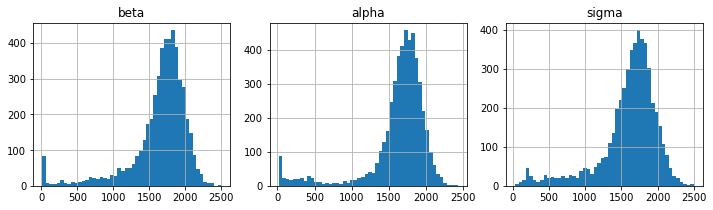

In [26]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_ess"].hist(bins=50, ax=ax);
    ax.set_title(varname)

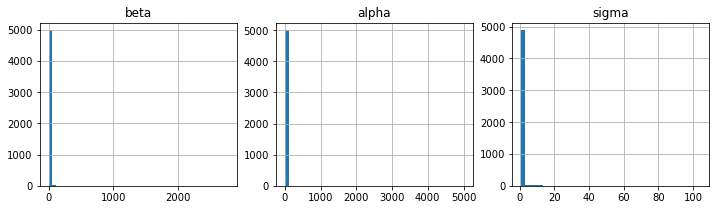

In [27]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_rhat"].hist(bins=50, ax=ax);
    ax.set_title(varname)

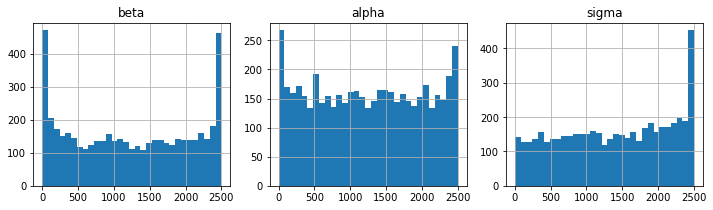

In [28]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_order_stat"].hist(bins=31, ax=ax);
    ax.set_title(varname)

## Correct prior

In [29]:
run_sbc2 = gen_sbc(true_model, bijectors, nchain, 500, 1000)

In [30]:
%%time
seed, inference_seed = jax.random.split(seed, 2)

result = run_sbc2([beta, alpha, sigma], y, inference_seed)
_ = result.block_until_ready()

/opt/miniconda3/lib/python3.8/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 14.1 s, sys: 131 ms, total: 14.2 s
Wall time: 14.2 s


In [31]:
# %%time
seed, *inference_seed = jax.random.split(seed, num_sbc_reps+1)

sbc_result = np.zeros((num_sbc_reps, 18))
for i in trange(num_sbc_reps):
    sbc_result[i] = run_sbc2(
        [beta_sbc[i], alpha_sbc[i], sigma_sbc[i]], y_sbc[i], inference_seed[i])

# sbc_result = jax.vmap(run_sbc2)(
#     [beta_sbc, alpha_sbc, sigma_sbc], y_sbc, jnp.asarray(inference_seed))
# _ = sbc_result.block_until_ready()

100%|██████████| 5000/5000 [03:57<00:00, 21.08it/s]


In [32]:
df_reps = pd.DataFrame(sbc_result, columns=name_all)
df_reps.head()

,beta_order_stat,alpha_order_stat,sigma_order_stat,beta_mean_stat,alpha_mean_stat,sigma_mean_stat,beta_rmse_mean,alpha_rmse_mean,sigma_rmse_mean,beta_rmse_averaged,alpha_rmse_averaged,sigma_rmse_averaged,beta_ess,alpha_ess,sigma_ess,beta_rhat,alpha_rhat,sigma_rhat
0,1538.0,1373.0,106.0,0.6152,0.5492,0.0424,0.024540,0.081603,0.771851,5.039703,27.784359,43.289192,1639.470337,1745.342529,1877.640869,0.998402,0.998821,1.004808
1,670.0,1870.0,1009.0,0.2680,0.7480,0.4036,0.042257,0.240589,0.025718,4.182366,23.175377,14.699378,1799.656250,1768.296509,1868.985107,1.001588,1.000304,0.998491
2,1815.0,1986.0,1133.0,0.7260,0.7944,0.4532,0.000115,0.000861,0.000003,0.011111,0.068783,0.040398,1770.912354,1816.379883,1652.171875,1.000634,1.000375,1.003714
3,502.0,371.0,2480.0,0.2008,0.1484,0.9920,0.069426,0.483364,0.637003,5.513948,34.203403,36.294724,1811.167969,1289.375000,1946.024170,1.002601,1.004364,0.999026
4,314.0,1507.0,585.0,0.1256,0.6028,0.2340,0.264817,0.337665,0.525393,17.763994,68.313194,46.966690,1953.303711,1842.533936,2204.641602,1.001640,0.999931,0.999200


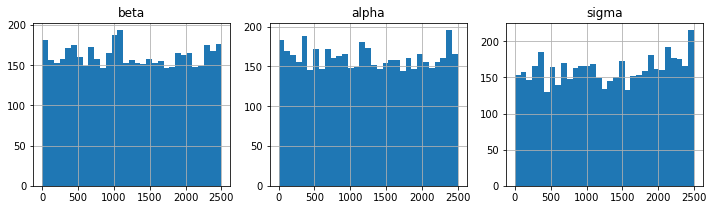

In [33]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_order_stat"].hist(bins=31, ax=ax);
    ax.set_title(varname)

In [40]:
df_reps = df_reps[(df_reps["beta_rhat"] < 1.1) & (df_reps["beta_ess"] > 1000)]

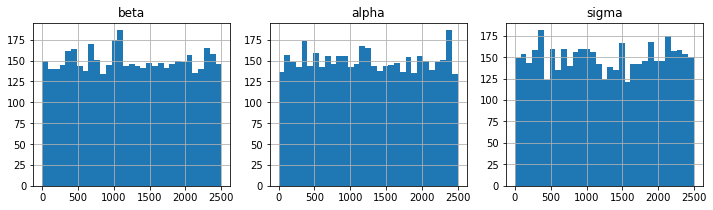

In [41]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_order_stat"].hist(bins=31, ax=ax);
    ax.set_title(varname)

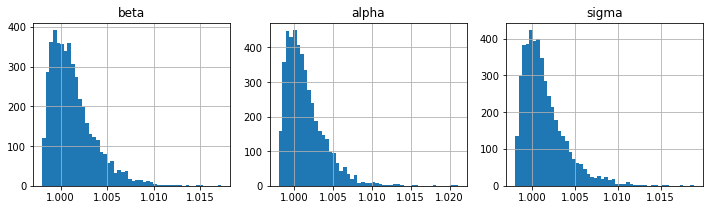

In [42]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, varname in zip(axes, ['beta', 'alpha', 'sigma']):
    df_reps[f"{varname}_rhat"].hist(bins=50, ax=ax);
    ax.set_title(varname)